In [1]:
import ctapipe

## Basic Infomrmation reading by ctapipe
It's easy to read simtel file by ctapipe. We can use the `EventSource` to read the simtel file and get the basic simulation information.

In [2]:
from ctapipe.io import EventSource
from ctapipe.calib import CameraCalibrator
from ctapipe.visualization import CameraDisplay
from ctapipe.image import hillas_parameters, tailcuts_clean
import matplotlib.pyplot as plt

# Open the simtel file
source = EventSource("simtel.zst", max_events=5)

for event in source:
    print(event.count, event.index.event_id, event.simulation.shower.energy)
    # Trigger telescope id
    print(event.r1.tel.keys()) 


/data/home/zzp/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0 100 100.0 TeV
dict_keys([1, 2, 3, 4])
1 101 100.0 TeV
dict_keys([1, 2, 3])
2 102 100.0 TeV
dict_keys([2, 3])
3 103 100.0 TeV
dict_keys([1, 2, 4])
4 104 100.0 TeV
dict_keys([1, 4])


## Read the raw data
Here, we read the ADC counts for the telscope1. We can see that the ADC counts have two gains. Here in the simulation, we show the sample of high/low gain.

In [3]:
r0tel = event.r0.tel[1]
r0tel.waveform

array([[[246, 254, 243, ..., 266, 249, 255],
        [242, 246, 248, ..., 240, 244, 249],
        [255, 267, 267, ..., 248, 240, 247],
        ...,
        [242, 248, 245, ..., 256, 265, 270],
        [265, 271, 264, ..., 244, 256, 262],
        [250, 251, 244, ..., 242, 246, 247]],

       [[249, 251, 252, ..., 250, 253, 247],
        [250, 250, 249, ..., 251, 248, 251],
        [252, 252, 251, ..., 251, 250, 249],
        ...,
        [250, 250, 249, ..., 250, 250, 249],
        [250, 251, 250, ..., 249, 250, 253],
        [250, 250, 248, ..., 246, 248, 246]]], dtype=uint16)

In [4]:
# ADC counts have two gains, sample number is 16 for HESS electronics
print(r0tel.waveform.shape)

(2, 1436, 16)


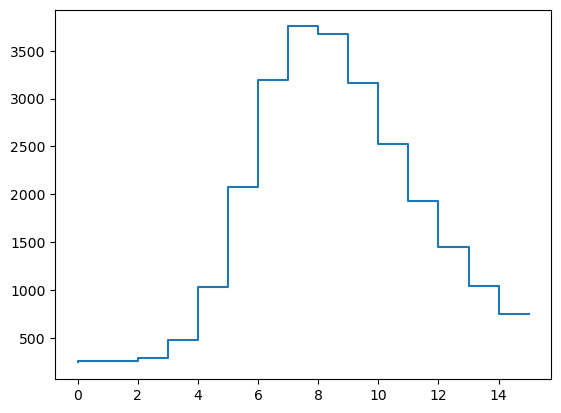

In [5]:
## We could plot the trace of one pixel (pedestal is 250 here)
trace = r0tel.waveform[0][1000]
plt.plot(trace, drawstyle="steps")

In [6]:

# Calibrate the data
calibrator = CameraCalibrator(subarray=source.subarray)
calibrated_event = calibrator(event)
for tel_id in event.dl1.tel:
     print("TEL{:03}: {}".format(tel_id, source.subarray.tel[tel_id]))
     print("  - r0  wave shape  : {}".format(event.r0.tel[tel_id].waveform.shape))
     print("  - r1  wave shape  : {}".format(event.r1.tel[tel_id].waveform.shape))
     print("  - dl1 image shape : {}".format(event.dl1.tel[tel_id].image.shape))


TEL001: SST_UNKNOWN-30M2_UNKNOWN-1436PX
  - r0  wave shape  : (2, 1436, 16)
  - r1  wave shape  : (1, 1436, 16)
  - dl1 image shape : (1436,)
TEL004: SST_UNKNOWN-30M2_UNKNOWN-1436PX
  - r0  wave shape  : (2, 1436, 16)
  - r1  wave shape  : (1, 1436, 16)
  - dl1 image shape : (1436,)


**After calibration, we can get the pe in each pixel**

In [7]:
tel_id = sorted(event.r1.tel.keys())[1]
sub = source.subarray
geometry = sub.tel[tel_id].camera.geometry
image = event.dl1.tel[tel_id].image

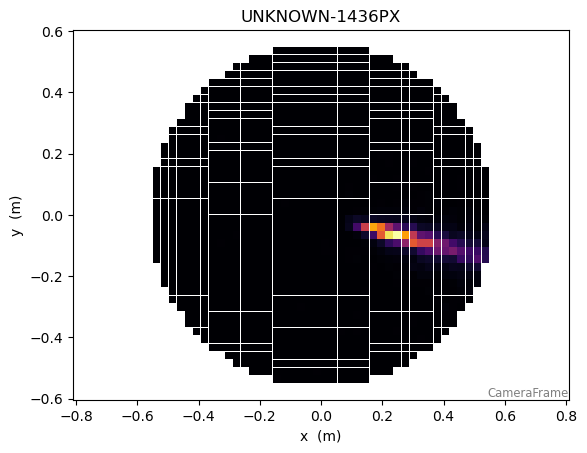

In [8]:
# Display the image
disp = CameraDisplay(geometry, image=image)
#disp.highlight_pixels(image > 3, color="white", alpha=0.3, linewidth=2)

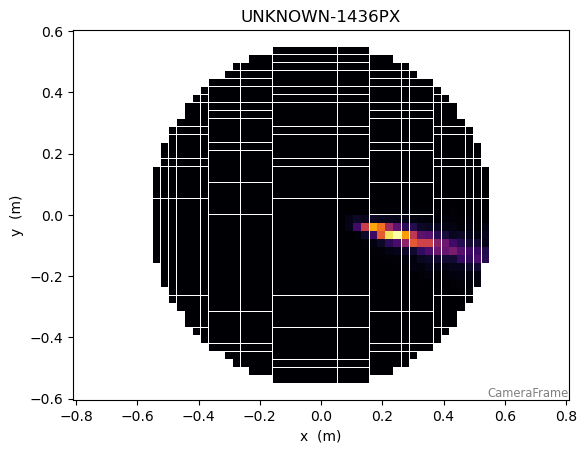

In [9]:

mask = tailcuts_clean(
     geometry,
     image,
     picture_thresh=10,
     boundary_thresh=5,
     min_number_picture_neighbors=2,
 )
cleaned = image.copy()
cleaned[~mask] = 0
disp = CameraDisplay(geometry, image=cleaned)


In [10]:
 params = hillas_parameters(geometry, cleaned)
 print(params)
 params

{'intensity': 15957.514511585236,
 'kurtosis': 2.1661100953504504,
 'length': <Quantity 0.11214827 m>,
 'length_uncertainty': <Quantity 0.00047935 m>,
 'phi': <Angle -0.25530527 rad>,
 'psi': <Angle -0.254465 rad>,
 'r': <Quantity 0.31887345 m>,
 'skewness': 0.30605138462446,
 'width': <Quantity 0.02904653 m>,
 'width_uncertainty': <Quantity 0.00025386 m>,
 'x': <Quantity 0.30853757 m>,
 'y': <Quantity -0.08052856 m>}


ctapipe.containers.CameraHillasParametersContainer:
                     intensity: total intensity (size) with default nan
                      skewness: measure of the asymmetry with default nan
                      kurtosis: measure of the tailedness with default nan
                             x: centroid x coordinate with default nan m [m]
                             y: centroid x coordinate with default nan m [m]
                             r: radial coordinate of centroid with default nan m
                                [m]
                           phi: polar coordinate of centroid with default nan
                                deg [deg]
                        length: standard deviation along the major-axis with
                                default nan m [m]
            length_uncertainty: uncertainty of length with default nan m [m]
                         width: standard spread along the minor-axis with
                                default nan m [m]
        

(-0.5805285563576886, 0.41947144364231137)

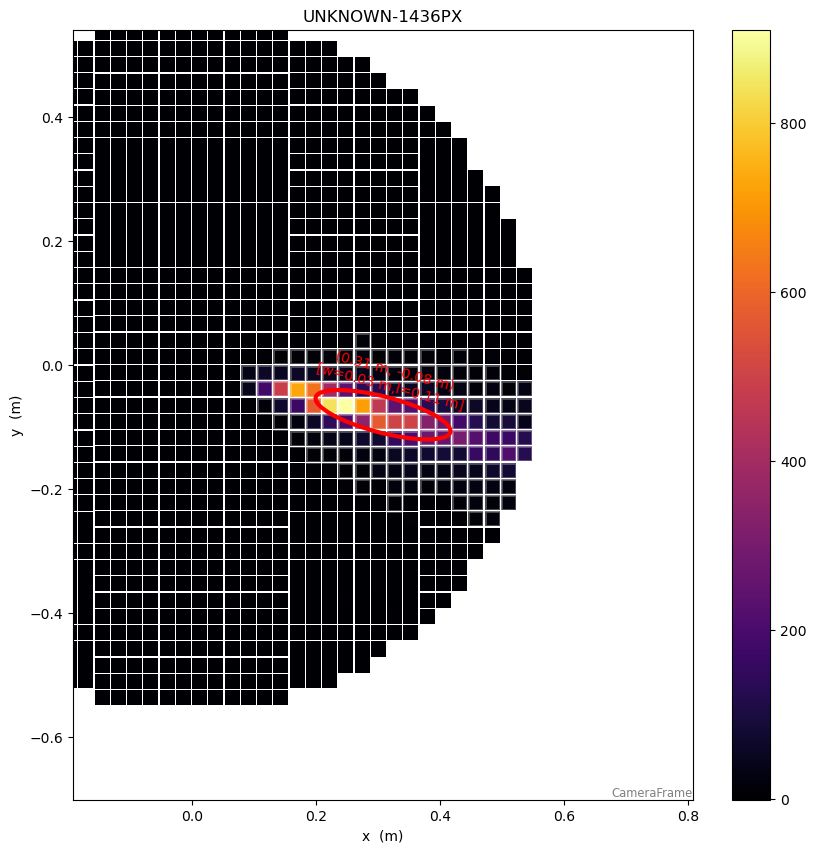

In [11]:
 from astropy import units as u
 params = hillas_parameters(geometry, cleaned)

 plt.figure(figsize=(10, 10))
 disp = CameraDisplay(geometry, image=image)
 disp.add_colorbar()
 disp.overlay_moments(params, color="red", lw=3)
 disp.highlight_pixels(mask, color="white", alpha=0.3, linewidth=2)

 plt.xlim(params.x.to_value(u.m) - 0.5, params.x.to_value(u.m) + 0.5)
 plt.ylim(params.y.to_value(u.m) - 0.5, params.y.to_value(u.m) + 0.5)